In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch import DeepLabV3

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, 1.0, 1.0)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV4(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv0(x))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = F.relu(self.conv1(cloud_phase_pred))
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV4().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")


100%|██████████| 94/94 [00:33<00:00,  2.83it/s]


Epoch: 1 | Train Loss: 8.3392 | Val Loss: 6.9271 | Val Mask: 0.8289 | Val Phase: 0.5955 | Val Cod: 0.0149 | Val Cps: -0.8523


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 2 | Train Loss: 5.0728 | Val Loss: 5.6160 | Val Mask: 0.8567 | Val Phase: 0.6676 | Val Cod: 0.1814 | Val Cps: -0.4637


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 3 | Train Loss: 3.9019 | Val Loss: 3.3103 | Val Mask: 0.8868 | Val Phase: 0.7495 | Val Cod: 0.3922 | Val Cps: 0.3232


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 4 | Train Loss: 3.2371 | Val Loss: 3.3261 | Val Mask: 0.9031 | Val Phase: 0.7250 | Val Cod: 0.3971 | Val Cps: 0.3050


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 5 | Train Loss: 2.8223 | Val Loss: 2.8783 | Val Mask: 0.9099 | Val Phase: 0.7779 | Val Cod: 0.3906 | Val Cps: 0.4375


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 6 | Train Loss: 2.5560 | Val Loss: 2.9938 | Val Mask: 0.8978 | Val Phase: 0.7586 | Val Cod: 0.2847 | Val Cps: 0.4760


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 7 | Train Loss: 2.3686 | Val Loss: 2.7141 | Val Mask: 0.9122 | Val Phase: 0.7298 | Val Cod: 0.5300 | Val Cps: 0.4892


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 8 | Train Loss: 2.2246 | Val Loss: 2.4885 | Val Mask: 0.8864 | Val Phase: 0.7954 | Val Cod: 0.5568 | Val Cps: 0.5125


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 9 | Train Loss: 2.1274 | Val Loss: 2.5260 | Val Mask: 0.8958 | Val Phase: 0.7797 | Val Cod: 0.5427 | Val Cps: 0.5122


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 10 | Train Loss: 2.0404 | Val Loss: 2.4884 | Val Mask: 0.9002 | Val Phase: 0.7964 | Val Cod: 0.4876 | Val Cps: 0.5367


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 11 | Train Loss: 1.9790 | Val Loss: 2.2244 | Val Mask: 0.9200 | Val Phase: 0.8085 | Val Cod: 0.4961 | Val Cps: 0.5981


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 12 | Train Loss: 1.9316 | Val Loss: 2.1403 | Val Mask: 0.9258 | Val Phase: 0.8169 | Val Cod: 0.5373 | Val Cps: 0.6014


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 13 | Train Loss: 1.8881 | Val Loss: 2.0842 | Val Mask: 0.9222 | Val Phase: 0.8141 | Val Cod: 0.5938 | Val Cps: 0.6073


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 14 | Train Loss: 1.8454 | Val Loss: 2.1604 | Val Mask: 0.9115 | Val Phase: 0.8153 | Val Cod: 0.5795 | Val Cps: 0.5931


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 15 | Train Loss: 1.8091 | Val Loss: 2.0551 | Val Mask: 0.9303 | Val Phase: 0.8117 | Val Cod: 0.5943 | Val Cps: 0.6144


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 16 | Train Loss: 1.7732 | Val Loss: 2.1664 | Val Mask: 0.9203 | Val Phase: 0.8082 | Val Cod: 0.5566 | Val Cps: 0.5955


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 17 | Train Loss: 1.7494 | Val Loss: 2.2286 | Val Mask: 0.9145 | Val Phase: 0.8171 | Val Cod: 0.5842 | Val Cps: 0.5531


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch: 18 | Train Loss: 1.7336 | Val Loss: 2.0168 | Val Mask: 0.9248 | Val Phase: 0.8227 | Val Cod: 0.6077 | Val Cps: 0.6185


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 19 | Train Loss: 1.7027 | Val Loss: 2.2065 | Val Mask: 0.9329 | Val Phase: 0.8238 | Val Cod: 0.4535 | Val Cps: 0.5927


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 20 | Train Loss: 1.6821 | Val Loss: 1.9187 | Val Mask: 0.9347 | Val Phase: 0.8278 | Val Cod: 0.6139 | Val Cps: 0.6338


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 21 | Train Loss: 1.6669 | Val Loss: 1.8171 | Val Mask: 0.9389 | Val Phase: 0.8307 | Val Cod: 0.6438 | Val Cps: 0.6556


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 22 | Train Loss: 1.6472 | Val Loss: 1.9335 | Val Mask: 0.9352 | Val Phase: 0.8272 | Val Cod: 0.5825 | Val Cps: 0.6408


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 23 | Train Loss: 1.6323 | Val Loss: 2.0360 | Val Mask: 0.9157 | Val Phase: 0.8227 | Val Cod: 0.6062 | Val Cps: 0.6169


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 24 | Train Loss: 1.6376 | Val Loss: 2.0318 | Val Mask: 0.9149 | Val Phase: 0.8226 | Val Cod: 0.6153 | Val Cps: 0.6115


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 25 | Train Loss: 1.6062 | Val Loss: 1.8977 | Val Mask: 0.9343 | Val Phase: 0.8279 | Val Cod: 0.6478 | Val Cps: 0.6262


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 26 | Train Loss: 1.5889 | Val Loss: 1.8154 | Val Mask: 0.9379 | Val Phase: 0.8278 | Val Cod: 0.6416 | Val Cps: 0.6597


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 27 | Train Loss: 1.5732 | Val Loss: 1.9407 | Val Mask: 0.9243 | Val Phase: 0.8318 | Val Cod: 0.6078 | Val Cps: 0.6315


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 28 | Train Loss: 1.5622 | Val Loss: 1.8051 | Val Mask: 0.9389 | Val Phase: 0.8316 | Val Cod: 0.6329 | Val Cps: 0.6652


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 29 | Train Loss: 1.5554 | Val Loss: 1.8936 | Val Mask: 0.9315 | Val Phase: 0.8331 | Val Cod: 0.6122 | Val Cps: 0.6394


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 30 | Train Loss: 1.5534 | Val Loss: 1.8846 | Val Mask: 0.9353 | Val Phase: 0.8100 | Val Cod: 0.6557 | Val Cps: 0.6501


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 31 | Train Loss: 1.5335 | Val Loss: 1.9711 | Val Mask: 0.9348 | Val Phase: 0.8082 | Val Cod: 0.6356 | Val Cps: 0.6288


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 32 | Train Loss: 1.5269 | Val Loss: 1.7947 | Val Mask: 0.9393 | Val Phase: 0.8253 | Val Cod: 0.6418 | Val Cps: 0.6724


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 33 | Train Loss: 1.5130 | Val Loss: 1.7642 | Val Mask: 0.9389 | Val Phase: 0.8363 | Val Cod: 0.6474 | Val Cps: 0.6705


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 34 | Train Loss: 1.5096 | Val Loss: 1.7944 | Val Mask: 0.9276 | Val Phase: 0.8334 | Val Cod: 0.6649 | Val Cps: 0.6643


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 35 | Train Loss: 1.5037 | Val Loss: 1.7936 | Val Mask: 0.9396 | Val Phase: 0.8377 | Val Cod: 0.6048 | Val Cps: 0.6729


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 36 | Train Loss: 1.5000 | Val Loss: 1.7802 | Val Mask: 0.9366 | Val Phase: 0.8366 | Val Cod: 0.6637 | Val Cps: 0.6587


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 37 | Train Loss: 1.4824 | Val Loss: 1.7519 | Val Mask: 0.9375 | Val Phase: 0.8344 | Val Cod: 0.6741 | Val Cps: 0.6616


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 38 | Train Loss: 1.4756 | Val Loss: 1.7825 | Val Mask: 0.9384 | Val Phase: 0.8247 | Val Cod: 0.6624 | Val Cps: 0.6661


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 39 | Train Loss: 1.4673 | Val Loss: 1.7993 | Val Mask: 0.9385 | Val Phase: 0.8378 | Val Cod: 0.6591 | Val Cps: 0.6471


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 40 | Train Loss: 1.4658 | Val Loss: 1.8517 | Val Mask: 0.9390 | Val Phase: 0.8188 | Val Cod: 0.6207 | Val Cps: 0.6663


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 41 | Train Loss: 1.4601 | Val Loss: 1.7133 | Val Mask: 0.9398 | Val Phase: 0.8374 | Val Cod: 0.6714 | Val Cps: 0.6747


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 42 | Train Loss: 1.4544 | Val Loss: 1.8195 | Val Mask: 0.9403 | Val Phase: 0.8318 | Val Cod: 0.6453 | Val Cps: 0.6482


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 43 | Train Loss: 1.4512 | Val Loss: 1.7943 | Val Mask: 0.9410 | Val Phase: 0.8229 | Val Cod: 0.6577 | Val Cps: 0.6682


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 44 | Train Loss: 1.4399 | Val Loss: 1.7427 | Val Mask: 0.9411 | Val Phase: 0.8379 | Val Cod: 0.6641 | Val Cps: 0.6647


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 45 | Train Loss: 1.4324 | Val Loss: 1.7170 | Val Mask: 0.9398 | Val Phase: 0.8293 | Val Cod: 0.6791 | Val Cps: 0.6805


100%|██████████| 94/94 [00:29<00:00,  3.14it/s]


Epoch: 46 | Train Loss: 1.4278 | Val Loss: 1.8552 | Val Mask: 0.9302 | Val Phase: 0.8318 | Val Cod: 0.6729 | Val Cps: 0.6344


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 47 | Train Loss: 1.4247 | Val Loss: 1.7185 | Val Mask: 0.9420 | Val Phase: 0.8376 | Val Cod: 0.6749 | Val Cps: 0.6715


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 48 | Train Loss: 1.4177 | Val Loss: 1.8377 | Val Mask: 0.9372 | Val Phase: 0.8114 | Val Cod: 0.6686 | Val Cps: 0.6642


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 49 | Train Loss: 1.4131 | Val Loss: 1.6831 | Val Mask: 0.9425 | Val Phase: 0.8383 | Val Cod: 0.6866 | Val Cps: 0.6767


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 50 | Train Loss: 1.4112 | Val Loss: 1.7031 | Val Mask: 0.9423 | Val Phase: 0.8383 | Val Cod: 0.6703 | Val Cps: 0.6752


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 51 | Train Loss: 1.4028 | Val Loss: 1.8839 | Val Mask: 0.9294 | Val Phase: 0.8295 | Val Cod: 0.6755 | Val Cps: 0.6332


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 52 | Train Loss: 1.4022 | Val Loss: 1.7201 | Val Mask: 0.9420 | Val Phase: 0.8338 | Val Cod: 0.6800 | Val Cps: 0.6721


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 53 | Train Loss: 1.3954 | Val Loss: 1.6810 | Val Mask: 0.9406 | Val Phase: 0.8387 | Val Cod: 0.6877 | Val Cps: 0.6805


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 54 | Train Loss: 1.3921 | Val Loss: 1.6642 | Val Mask: 0.9428 | Val Phase: 0.8409 | Val Cod: 0.6778 | Val Cps: 0.6858


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 55 | Train Loss: 1.3888 | Val Loss: 1.7869 | Val Mask: 0.9369 | Val Phase: 0.8340 | Val Cod: 0.6849 | Val Cps: 0.6557


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 56 | Train Loss: 1.3848 | Val Loss: 1.6937 | Val Mask: 0.9404 | Val Phase: 0.8408 | Val Cod: 0.6726 | Val Cps: 0.6773


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 57 | Train Loss: 1.3790 | Val Loss: 1.7064 | Val Mask: 0.9436 | Val Phase: 0.8413 | Val Cod: 0.6664 | Val Cps: 0.6730


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 58 | Train Loss: 1.3707 | Val Loss: 1.7737 | Val Mask: 0.9430 | Val Phase: 0.8349 | Val Cod: 0.6753 | Val Cps: 0.6486


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 59 | Train Loss: 1.3686 | Val Loss: 1.7326 | Val Mask: 0.9429 | Val Phase: 0.8244 | Val Cod: 0.6706 | Val Cps: 0.6834


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch: 60 | Train Loss: 1.3686 | Val Loss: 1.6908 | Val Mask: 0.9420 | Val Phase: 0.8377 | Val Cod: 0.6723 | Val Cps: 0.6864


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 61 | Train Loss: 1.3628 | Val Loss: 1.7480 | Val Mask: 0.9403 | Val Phase: 0.8170 | Val Cod: 0.6722 | Val Cps: 0.6851


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 62 | Train Loss: 1.3563 | Val Loss: 1.6892 | Val Mask: 0.9429 | Val Phase: 0.8338 | Val Cod: 0.6822 | Val Cps: 0.6830


100%|██████████| 94/94 [00:30<00:00,  3.13it/s]


Epoch: 63 | Train Loss: 1.3568 | Val Loss: 1.6951 | Val Mask: 0.9423 | Val Phase: 0.8408 | Val Cod: 0.6768 | Val Cps: 0.6746


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 64 | Train Loss: 1.3507 | Val Loss: 1.6845 | Val Mask: 0.9396 | Val Phase: 0.8291 | Val Cod: 0.6947 | Val Cps: 0.6886


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch: 65 | Train Loss: 1.3517 | Val Loss: 1.7657 | Val Mask: 0.9363 | Val Phase: 0.8217 | Val Cod: 0.6565 | Val Cps: 0.6827


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 66 | Train Loss: 1.3452 | Val Loss: 1.6892 | Val Mask: 0.9404 | Val Phase: 0.8406 | Val Cod: 0.6832 | Val Cps: 0.6769


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 67 | Train Loss: 1.3422 | Val Loss: 1.7827 | Val Mask: 0.9390 | Val Phase: 0.8213 | Val Cod: 0.6884 | Val Cps: 0.6838


100%|██████████| 94/94 [00:29<00:00,  3.13it/s]


Epoch: 68 | Train Loss: 1.3387 | Val Loss: 1.7024 | Val Mask: 0.9394 | Val Phase: 0.8377 | Val Cod: 0.6927 | Val Cps: 0.6732


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 69 | Train Loss: 1.3363 | Val Loss: 1.6984 | Val Mask: 0.9379 | Val Phase: 0.8319 | Val Cod: 0.6814 | Val Cps: 0.6852


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 70 | Train Loss: 1.3297 | Val Loss: 1.7608 | Val Mask: 0.9290 | Val Phase: 0.8306 | Val Cod: 0.6839 | Val Cps: 0.6679


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 71 | Train Loss: 1.3276 | Val Loss: 1.6555 | Val Mask: 0.9432 | Val Phase: 0.8416 | Val Cod: 0.6862 | Val Cps: 0.6850


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 72 | Train Loss: 1.3221 | Val Loss: 1.6490 | Val Mask: 0.9441 | Val Phase: 0.8418 | Val Cod: 0.6836 | Val Cps: 0.6910


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 73 | Train Loss: 1.3214 | Val Loss: 1.6863 | Val Mask: 0.9416 | Val Phase: 0.8405 | Val Cod: 0.6859 | Val Cps: 0.6751


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 74 | Train Loss: 1.3188 | Val Loss: 1.6904 | Val Mask: 0.9421 | Val Phase: 0.8391 | Val Cod: 0.6769 | Val Cps: 0.6825


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 75 | Train Loss: 1.3122 | Val Loss: 1.6645 | Val Mask: 0.9435 | Val Phase: 0.8423 | Val Cod: 0.6876 | Val Cps: 0.6844


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 76 | Train Loss: 1.3076 | Val Loss: 1.6627 | Val Mask: 0.9436 | Val Phase: 0.8428 | Val Cod: 0.6908 | Val Cps: 0.6804


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 77 | Train Loss: 1.3066 | Val Loss: 1.7822 | Val Mask: 0.9417 | Val Phase: 0.8261 | Val Cod: 0.6501 | Val Cps: 0.6772


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 78 | Train Loss: 1.3064 | Val Loss: 1.6567 | Val Mask: 0.9432 | Val Phase: 0.8391 | Val Cod: 0.6924 | Val Cps: 0.6899


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 79 | Train Loss: 1.3066 | Val Loss: 1.6897 | Val Mask: 0.9389 | Val Phase: 0.8431 | Val Cod: 0.6830 | Val Cps: 0.6785


100%|██████████| 94/94 [00:30<00:00,  3.10it/s]


Epoch: 80 | Train Loss: 1.2817 | Val Loss: 1.6292 | Val Mask: 0.9429 | Val Phase: 0.8464 | Val Cod: 0.6898 | Val Cps: 0.6907


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 81 | Train Loss: 1.2691 | Val Loss: 1.6294 | Val Mask: 0.9438 | Val Phase: 0.8477 | Val Cod: 0.6927 | Val Cps: 0.6859


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 82 | Train Loss: 1.2651 | Val Loss: 1.6803 | Val Mask: 0.9432 | Val Phase: 0.8293 | Val Cod: 0.6907 | Val Cps: 0.6857


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 83 | Train Loss: 1.2585 | Val Loss: 1.6079 | Val Mask: 0.9431 | Val Phase: 0.8462 | Val Cod: 0.6982 | Val Cps: 0.6902


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 84 | Train Loss: 1.2537 | Val Loss: 1.7463 | Val Mask: 0.9376 | Val Phase: 0.8344 | Val Cod: 0.6884 | Val Cps: 0.6633


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 85 | Train Loss: 1.2540 | Val Loss: 1.6221 | Val Mask: 0.9422 | Val Phase: 0.8417 | Val Cod: 0.6952 | Val Cps: 0.6900


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 86 | Train Loss: 1.2487 | Val Loss: 1.6605 | Val Mask: 0.9413 | Val Phase: 0.8428 | Val Cod: 0.6918 | Val Cps: 0.6793


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 87 | Train Loss: 1.2457 | Val Loss: 1.6536 | Val Mask: 0.9425 | Val Phase: 0.8435 | Val Cod: 0.6795 | Val Cps: 0.6826


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 88 | Train Loss: 1.2445 | Val Loss: 1.8620 | Val Mask: 0.9419 | Val Phase: 0.8240 | Val Cod: 0.6848 | Val Cps: 0.6427


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch: 89 | Train Loss: 1.2491 | Val Loss: 1.6263 | Val Mask: 0.9437 | Val Phase: 0.8466 | Val Cod: 0.6721 | Val Cps: 0.6943


100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch: 90 | Train Loss: 1.2380 | Val Loss: 1.6526 | Val Mask: 0.9418 | Val Phase: 0.8367 | Val Cod: 0.6809 | Val Cps: 0.6923


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 91 | Train Loss: 1.2334 | Val Loss: 1.6133 | Val Mask: 0.9433 | Val Phase: 0.8469 | Val Cod: 0.6933 | Val Cps: 0.6894


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 92 | Train Loss: 1.2292 | Val Loss: 1.7265 | Val Mask: 0.9430 | Val Phase: 0.8439 | Val Cod: 0.6750 | Val Cps: 0.6595


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 93 | Train Loss: 1.2292 | Val Loss: 1.6380 | Val Mask: 0.9413 | Val Phase: 0.8391 | Val Cod: 0.6984 | Val Cps: 0.6882


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 94 | Train Loss: 1.2255 | Val Loss: 1.6174 | Val Mask: 0.9439 | Val Phase: 0.8489 | Val Cod: 0.6920 | Val Cps: 0.6876


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 95 | Train Loss: 1.2260 | Val Loss: 1.6277 | Val Mask: 0.9435 | Val Phase: 0.8469 | Val Cod: 0.6767 | Val Cps: 0.6902


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 96 | Train Loss: 1.2185 | Val Loss: 1.6489 | Val Mask: 0.9420 | Val Phase: 0.8427 | Val Cod: 0.6941 | Val Cps: 0.6807


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 97 | Train Loss: 1.2202 | Val Loss: 1.6368 | Val Mask: 0.9431 | Val Phase: 0.8471 | Val Cod: 0.6930 | Val Cps: 0.6839


100%|██████████| 94/94 [00:28<00:00,  3.25it/s]


Epoch: 98 | Train Loss: 1.2175 | Val Loss: 1.6720 | Val Mask: 0.9439 | Val Phase: 0.8237 | Val Cod: 0.6961 | Val Cps: 0.6960


100%|██████████| 94/94 [00:29<00:00,  3.24it/s]


Epoch: 99 | Train Loss: 1.2125 | Val Loss: 1.6831 | Val Mask: 0.9427 | Val Phase: 0.8485 | Val Cod: 0.6880 | Val Cps: 0.6655


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 100 | Train Loss: 1.2100 | Val Loss: 1.5949 | Val Mask: 0.9435 | Val Phase: 0.8469 | Val Cod: 0.7017 | Val Cps: 0.6956


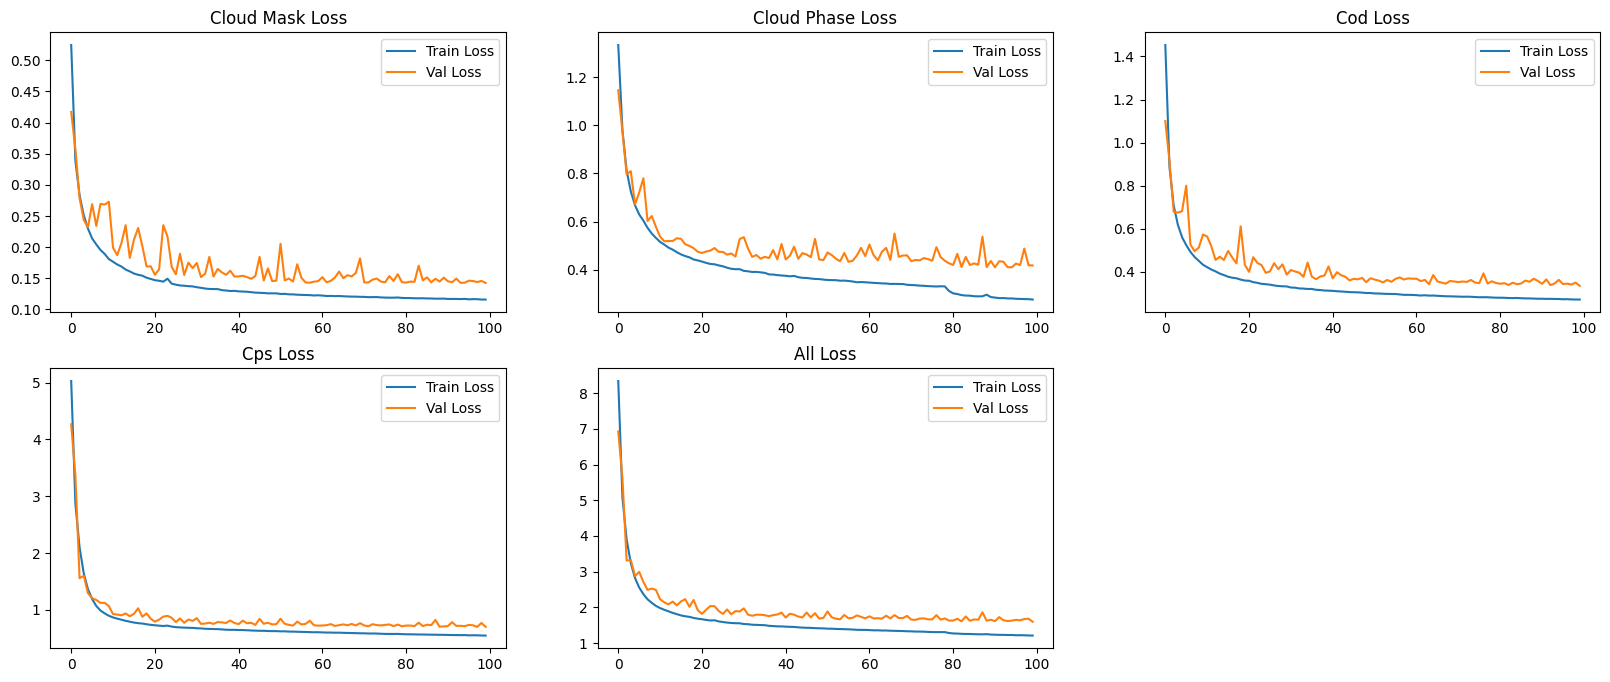

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV4_loss.png")  

plt.show()

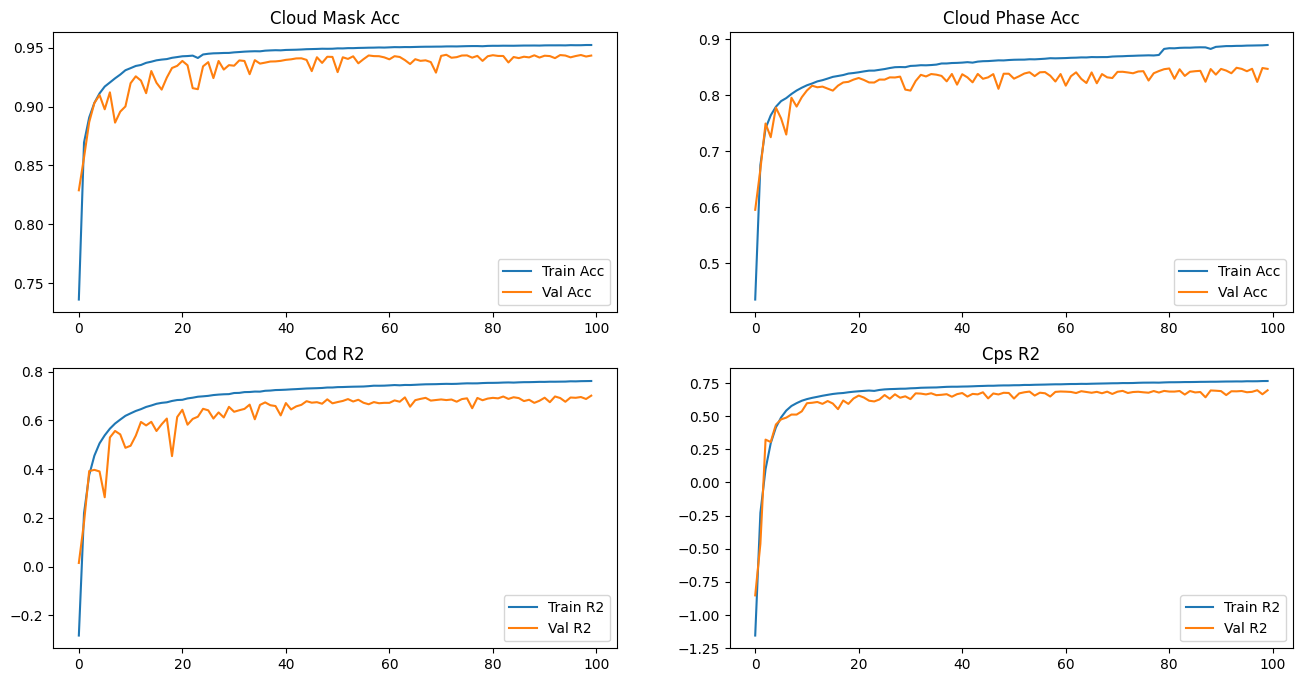

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.savefig("./graphs/MultiTaskV4_acc.png")  

plt.show()



In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.897     0.843     0.869   5803166
           1      0.952     0.970     0.961  18740066

    accuracy                          0.940  24543232
   macro avg      0.925     0.906     0.915  24543232
weighted avg      0.939     0.940     0.939  24543232

CONFUSION MATRIX:
 [[ 4890943   912223]
 [  562642 18177424]]

IOU: [0.76831456 0.924952  ]
Unweighted IoU: 0.846633281770021
Weighted IoU: 0.8879155960109004


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:02<00:00,  5.71it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.868     0.817     0.842   4373397
           1      0.844     0.900     0.871  10864796
           2      0.732     0.778     0.754   2400565
           3      0.495     0.389     0.436    890044
           4      0.909     0.844     0.876   6014430

    accuracy                          0.841  24543232
   macro avg      0.770     0.746     0.756  24543232
weighted avg      0.841     0.841     0.840  24543232

CONFUSION MATRIX:
 [[3571859  735455   15561    3078   47444]
 [ 457142 9781326  318688   50477  257163]
 [   9015  392735 1866956   85017   46842]
 [   2031  150019  237524  345933  154537]
 [  75399  534659  111492  213947 5078933]]

IOU: [0.72643291 0.77154009 0.60540172 0.27840279 0.77892776]
Unweighted IoU: 0.6321410528536713
Weighted IoU: 0.7311795185215716


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:02<00:00,  5.86it/s]


r2: 0.6968652606010437
MSE: 0.3489818274974823


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:02<00:00,  5.95it/s]


r2: 0.7004600763320923
MSE: 0.7196028828620911
